In [38]:
#!pip install --upgrade networkx==2.6
#!pip install --upgrade scipy==1.8.0
import networkx as nx #use scipy v1.8.0, networkx v2.6
import nltk
import datetime as dt
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from heapq import nlargest
from time import time
import requests
import re

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from tabulate import tabulate

## 1. Read Reddit Posts & Comments

In [2]:
df = pd.read_csv('predict_output_xgb.csv')
df = df.dropna(subset=['cleaned_content'])

#Get month and year
df['created'] = pd.to_datetime(df['created'], format = '%d/%m/%Y %H:%M')
df['month'] = df['created'].dt.month
df['year'] = df['created'].dt.year

#Get unique tokens
df['cleaned_unique'] = df['cleaned_content'].apply(lambda x: " ".join(np.unique([token for token in word_tokenize(x)])))

#Split into before and after release as well as positive and negative sentiments for both time periods
bef = df.loc[pd.to_datetime(df['created'])<dt.datetime(2023,2,7,6,0,0)].reset_index(drop = True)
bef_pos = bef.loc[bef['pred_sentiment'] == 'positive'].reset_index(drop = True)
bef_neg = bef.loc[bef['pred_sentiment'] == 'negative'].reset_index(drop = True)
aft = df.loc[pd.to_datetime(df['created'])>=dt.datetime(2023,2,7,6,0,0)].reset_index(drop = True)
aft_pos = aft.loc[aft['pred_sentiment'] == 'positive'].reset_index(drop = True)
aft_neg = aft.loc[aft['pred_sentiment'] == 'negative'].reset_index(drop = True)

In [3]:
def get_reviews(appid, params={'json':1}):
        url = 'https://store.steampowered.com/appreviews/'
        response = requests.get(url=url+appid, params=params, headers={'User-Agent': 'Mozilla/5.0'})
        return response.json()

In [4]:
# Obtaining only negative reviews
def get_n_reviews(appid, n=100):
    reviews = []
    cursor = '*'
    params = {
            'json' : 1,
            'filter' : 'all',
            'language' : 'english',
            'day_range' : 9223372036854775807,
            'review_type' : 'negative',
            'purchase_type' : 'all'
            }

    while n > 0:
        params['cursor'] = cursor.encode()
        params['num_per_page'] = min(100, n)
        n -= 100

        response = get_reviews(appid, params)
        cursor = response['cursor']
        reviews += response['reviews']

        if len(response['reviews']) < 100: break

    return reviews

## 2. Get Steam Reviews

In [5]:
# Input Hogwarts Legacy's AppID, and the number of reveiws to return
reviews = get_n_reviews("990080",10000)
steam_df = pd.DataFrame (reviews)

steam_df['timestamp_created'] = steam_df['timestamp_created'].apply(lambda d: dt.datetime.fromtimestamp(int(d)).strftime('%Y-%m-%d'))

In [6]:
#Only take reviews from 14th and before
steam_df = steam_df.loc[pd.to_datetime(steam_df['timestamp_created'])<dt.datetime(2023,2,15,0,0,0)].reset_index(drop = True)

In [7]:
#Define default english stop words and add 'game' to the list
stop_words = list(stopwords.words('english'))
stop_words.append('game')
lemmatizer = WordNetLemmatizer()
def preprocess_text(text):
    #Remove URLs
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    text = url_pattern.sub('', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Convert to lowercase
    text = text.lower()
    # Tokenize
    tokens = nltk.word_tokenize(text)
    # lemmatize
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Remove stop words
    tokens = [token for token in tokens if token not in stop_words]
    # Remove Nones
    tokens = list(filter(lambda x: x is not None, tokens))
    return ' '.join(tokens)

In [8]:
# Preprocess text
steam_df['cleaned'] = steam_df['review'].apply(preprocess_text)
steam_df['cleaned_unique'] = steam_df['cleaned'].apply(lambda x: " ".join(np.unique([token for token in word_tokenize(x)])))

In [13]:
#Function to return top 20 sentences using page rank algorithm
def pagerank(dataframe):
    sentences = dataframe['cleaned_unique']
    #Initialize graph object
    graph = nx.Graph()
    graph.add_nodes_from(range(len(sentences)))

    #Sentences are nodes. Edges are weighted by proportion of common words.
    for i in range(len(sentences)):
        curr = set(
            np.unique(
                [token for token in word_tokenize(sentences[i]) if (str(token).isalpha() == True)]
            )
        )
        for j in range(i + 1, len(sentences)):
            other = set(
                np.unique(
                    [token for token in word_tokenize(sentences[j]) if (str(token).isalpha() == True)]
                )
            )
            #Get proportion of common words
            common_prop = len(curr & other)*2/np.max([1, (len(curr) + len(other))])
            #Add edge between two nodes if common words prop > 1
            if common_prop > 0:
                graph.add_edge(i, j, weight = common_prop)

    #Calculate pagerank scores
    pagerank = nx.pagerank(graph)

    #Find top 10 sentences
    top_indexes = sorted(nlargest(10, pagerank, key = pagerank.get))
    return top_indexes, pagerank

## 3. Network Analysis

In [15]:
#Negative steam reviews
idx_steam, pr_steam = pagerank(steam_df)

In [67]:
#top 10 reviews in descending page rank
inv_steam = {value: key for key, value in pr_steam.items()}
inv_idx_steam = [inv_steam[i] for i in nlargest(20, sorted(inv_steam.keys(), reverse = True))]
for i, sentence in enumerate(steam_df.loc[inv_idx_steam,'review']):
    print(f"[rank {i}]:\n{sentence}")

[rank 0]:
I would recommend this any time. The game is an absolute dream for HP fans and just ticks every box for a good open world take on the wizarding world. 

But I can't recommend this game while it runs that bad on PC. I can run the Game on my config on Medium with DLSS on and it "works". Stutters are minimal but you can feel them. If I change the settings to low - high - ultra, the game is unplayable in hogwarts and hogsmead. I should easily run the game on high if not on Ultra on 1080p. Now the big oof: Its not just me. Everybody of my Friends who play this game as well are having the same issues. Running it perfectly on Ultra but in Hogwarts and Hogsmead the game just drops towards under 10 fps. 

There is a Patch needed asap to fix this. And if it is really the anti cheat then get rid of it asap to make it customer friendly.
[rank 1]:
RTX 3090
64 GB RAM
i9 12900K

average FPS- 35 (on any setting, it doesn't change regardless if on low or ultra weather RTX is on or off it neve

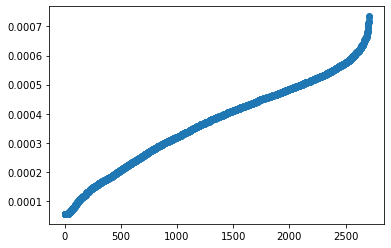

In [17]:
#scatter plot of pagerank score
plt.scatter(list(pr_steam.keys()),sorted(pr_steam.values()))

(array([191., 257., 263., 327., 371., 451., 440., 271., 116.,  20.]),
 array([5.57797073e-05, 1.23707390e-04, 1.91635073e-04, 2.59562755e-04,
        3.27490438e-04, 3.95418121e-04, 4.63345804e-04, 5.31273486e-04,
        5.99201169e-04, 6.67128852e-04, 7.35056534e-04]),
 <BarContainer object of 10 artists>)

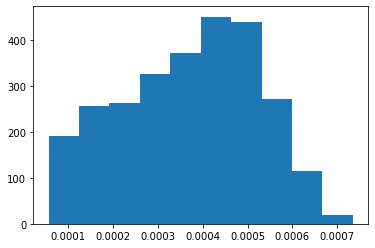

In [18]:
#histogram of pagerank score
plt.hist(pr_steam.values(), bins = 10)

In [ ]:
#Before positive
idx_bp, pr_bp = pagerank(bef_pos)

In [56]:
#Top 15 comments in descending page rank
inv_bp = {value: key for key, value in pr_bp.items()}
inv_idx_bp = [inv_bp[i] for i in nlargest(15, sorted(inv_bp.keys(), reverse = True))]
for i, sentence in enumerate(bef_pos.loc[inv_idx_bp,'content']):
    print(f"[rank {i}]:\n{sentence}")

[rank 0]:
That looks so good! God, I can’t wait until this game is out.
[rank 1]:
Will the game actually look this good??
[rank 2]:
Nope, I don't know why I would. As good as the game looks, I'm waiting for reviews.
[rank 3]:
fuck this game looks so good
[rank 4]:
Some good News. I really cant wait to Play this Game!
[rank 5]:
I am so excited for this game it looks amazing!
[rank 6]:
I'm buying the game just to explore Hogwarts. It looks amazing. If the gameplay is good, that's a bonus at this point.
[rank 7]:
They are in game renders, they look so good
[rank 8]:
 I'm getting good feelings about this game after the latest video. Definitely looks like something I'm going to waste countless hours on.

&#x200B;

 Also that coat the character was wearing was cool.
[rank 9]:
If the game is as good as it it looks, I’ll do two plays one as Ravenclaw and the next as Slytherin.
[rank 10]:
No in game schedule so not really Bully 2. The game does look good though and I am even more excited for it

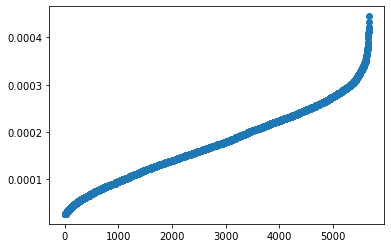

In [21]:
plt.scatter(list(pr_bp.keys()),sorted(pr_bp.values()))

(array([ 485.,  843.,  997., 1005.,  957.,  763.,  421.,  156.,   36.,
          10.]),
 array([2.64767402e-05, 6.83133913e-05, 1.10150042e-04, 1.51986694e-04,
        1.93823345e-04, 2.35659996e-04, 2.77496647e-04, 3.19333298e-04,
        3.61169949e-04, 4.03006600e-04, 4.44843252e-04]),
 <BarContainer object of 10 artists>)

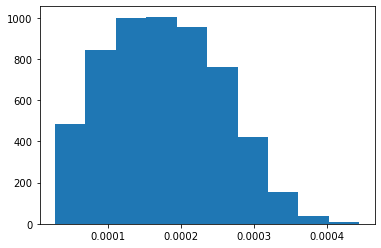

In [22]:
plt.hist(pr_bp.values(), bins = 10)

In [23]:
#Before negative
idx_bn, pr_bn = pagerank(bef_neg)

In [54]:
#Top 15 posts/comments in descending page rank
inv_bn = {value: key for key, value in pr_bn.items()}
inv_idx_bn = [inv_bn[i] for i in nlargest(15, sorted(inv_bn.keys(), reverse = True))]

for i, sentence in enumerate(bef_neg.loc[inv_idx_bn,'content']):
    print(f"[rank {i}]:\n{sentence}")

[rank 0]:
They seem like the really want peoples money. I hope the game itself  is good.
[rank 1]:
I really hope this game is good otherwise your gonna be like those people who got cyberpunk tats and stuff lol
[rank 2]:
It’s not even out yet! I hope you like the game man….
[rank 3]:
Other people: this game is not gonna do well it doesn't look good 
Me: Dude, it's Harry Potter. It WILL do well.
[rank 4]:
I'm very excited but I feel like from reading this sub a lot of people have unrealistic expectations for this game and will be disappointed.
[rank 5]:
This game gonna sell like crazy, i hope it doesn't disappoint.
[rank 6]:
With a lot of new people getting into video games due to this game, you can not really fault them for being excited about something like this
[rank 7]:
It’s pretty rare that a game gets people excited like this one has. I can’t remember the last time I routinely checked my calendar in anticipation like this, so I’m right there with you.
[rank 8]:
Looks like one of th

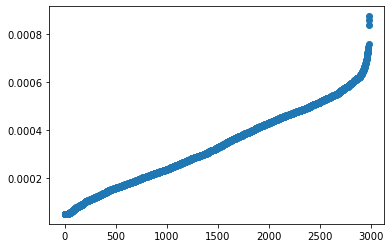

In [25]:
plt.scatter(list(pr_bn.keys()),sorted(pr_bn.values()))

(array([369., 492., 498., 387., 442., 454., 258.,  67.,  15.,   3.]),
 array([5.05246139e-05, 1.32793594e-04, 2.15062573e-04, 2.97331553e-04,
        3.79600533e-04, 4.61869513e-04, 5.44138492e-04, 6.26407472e-04,
        7.08676452e-04, 7.90945432e-04, 8.73214411e-04]),
 <BarContainer object of 10 artists>)

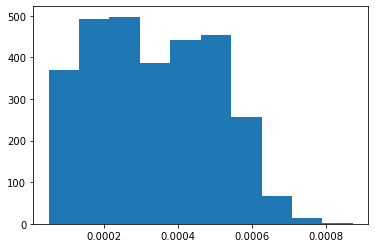

In [26]:
plt.hist(pr_bn.values(), bins = 10)

In [27]:
#After positive
idx_ap, pr_ap = pagerank(aft_pos)

In [63]:
#top 15 posts/comments in descending page rank
inv_ap = {value: key for key, value in pr_ap.items()}
inv_idx_ap = [inv_ap[i] for i in nlargest(15, sorted(inv_ap.keys(), reverse = True))]

for i, sentence in enumerate(aft_pos.loc[inv_idx_ap,'content']):
    print(f"[rank {i}]:\n{sentence}")

[rank 0]:
Before playing it I was like "nahh too many good games" but now I'm definitely considering it GOTY material, it's everything I wanted and so much more, even after 20+ hours I keep seeing new content all the time and there's a lot to look forward to.
[rank 1]:
Im soo happy right now. I would never expect getting really good and amazing game like this, because most of the time, every new games are just at best ok.
[rank 2]:
Yeah, I love that.  It feels like a callback to the first two PC Harry Potter games where Harry would whisper the spells when he was under the invisibility cloak.
[rank 3]:
I always used to say Fable was the Harry Potter games we never got and here 15+ years later it feels like we finally got it. I love fable and also had the same feeling playing this
[rank 4]:
Yes yes yes!!!!! I love this game!!!! I was 13 in 2001 when the first movie came out so I’ve been living Harry Potter for a LONG time lol
[rank 5]:
While I haven't played for too long as of yet, what 

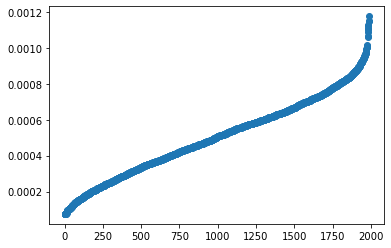

In [29]:
plt.scatter(list(pr_ap.keys()),sorted(pr_ap.values()))

(array([153., 252., 305., 320., 349., 295., 196.,  88.,  20.,   9.]),
 array([7.56849488e-05, 1.85693903e-04, 2.95702857e-04, 4.05711811e-04,
        5.15720765e-04, 6.25729719e-04, 7.35738673e-04, 8.45747627e-04,
        9.55756581e-04, 1.06576554e-03, 1.17577449e-03]),
 <BarContainer object of 10 artists>)

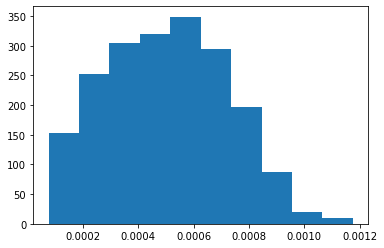

In [30]:
plt.hist(pr_ap.values(), bins = 10)

In [31]:
#After negative
idx_an, pr_an = pagerank(aft_neg)

In [65]:
#top 15 posts/comments in descending page rank
inv_an = {value: key for key, value in pr_an.items()}
inv_idx_an = [inv_an[i] for i in nlargest(15, sorted(inv_an.keys(), reverse = True))]

for i, sentence in enumerate(aft_neg.loc[inv_idx_an,'content']):
    print(f"[rank {i}]:\n{sentence}")

[rank 0]:
When I first heard her say that, I was like "What? This is the 1800s, you can't have a wife!"

Honestly feels like this game should be set in the 2020s.
[rank 1]:
I’m level 20 and the only time I’ve been in the common room was at the beginning of the game. I don’t even know how to get to my common room.
[rank 2]:
I'd also love it if something was added to make the students more interactive, even adding collision would help. I also wish you could use magic on everyone like you could in the order of the phoenix game.
[rank 3]:
Do we get to have animals at some point in the game like a niffler ? ![img](emote|t5_q8ebh|26542)
[rank 4]:
I've had a chest glitch out. Couldn't open it because my slots were full.  Couldn't reset it any way because I was on the way to get that book in the restricted area of the library. Went back down there and the chest was now empty. Like my only one gripe with this game so far. Well that and the map. It's very unintuitive.
[rank 5]:
yeah theres like 

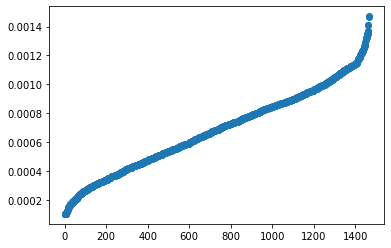

In [33]:
plt.scatter(list(pr_an.keys()),sorted(pr_an.values()))

(array([ 77., 179., 211., 214., 222., 239., 172., 109.,  33.,  10.]),
 array([0.00010268, 0.00023952, 0.00037637, 0.00051321, 0.00065006,
        0.0007869 , 0.00092375, 0.00106059, 0.00119744, 0.00133428,
        0.00147113]),
 <BarContainer object of 10 artists>)

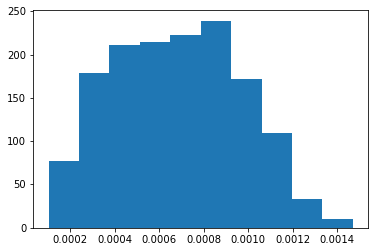

In [34]:
plt.hist(pr_an.values(), bins = 10)

## 4. Topic Modelling

In [46]:
def nmf(data):
    #Remove tokens that do not appear in at least 50 documents
    vect = TfidfVectorizer(min_df=50, stop_words='english')

    # Fit and transform
    X = vect.fit_transform(data)

    # Initialize NMF model with 10 topics
    model = NMF(n_components=10, random_state=5)
    model.fit(X)
    nmf_features = model.transform(X)

    # Create a df of the model components
    components_df = pd.DataFrame(model.components_, columns=vect.get_feature_names_out())
    
    # Create a dict and show results
    d = {'Topic': [], 'Words': []}
    
    for topic in range(components_df.shape[0]):
        words = components_df.iloc[topic]
        words = ', '.join(words.nlargest(10).index)
        d['Topic'].append(topic)
        d['Words'].append(words)
    print(tabulate(d, tablefmt = "grid", headers = ["Topic", "Words"]))
        
    return model, nmf_features

def plot_topic_freq(model, nmf_features, title):
    # Count the document frequency of each topic
    topic_freq = [0] * model.n_components
    for doc in nmf_features:
        topic = doc.argmax()
        topic_freq[topic] += 1

    # Plot a bar chart to show the frequency
    fig, ax = plt.subplots(figsize = (12,8))
    ax.set_title(title)
    ax.bar(range(10), topic_freq)
    ax.set_xlabel("Topic")
    ax.set_ylabel("Number of Documents containing topic")
    ax.set_xticks(range(10))
    plt.show()

In [39]:
#Negative steam reviews
steam_model, steam_features = nmf(steam_df['review'])

+---------+------------------------------------------------------------------------------------+
|   Topic | Words                                                                              |
+=========+====================================================================================+
|       0 | just, world, like, story, hogwarts, really, potter, harry, character, combat       |
+---------+------------------------------------------------------------------------------------+
|       1 | game, great, good, fun, recommend, run, optimization, buy, review, graphics        |
+---------+------------------------------------------------------------------------------------+
|       2 | performance, issues, fixed, recommend, bad, horrible, good, poor, awful, fun       |
+---------+------------------------------------------------------------------------------------+
|       3 | fps, drops, settings, frame, ram, unplayable, rtx, low, stuttering, stutters       |
+---------+-------------------

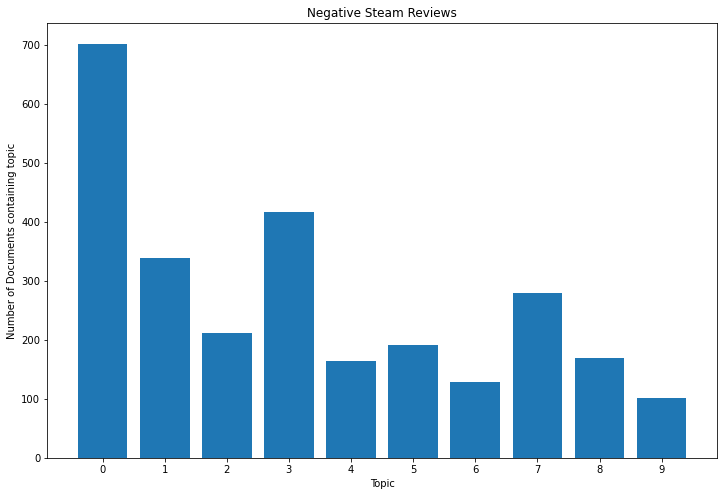

In [47]:
plot_topic_freq(steam_model, steam_features, "Negative Steam Reviews")

In [48]:
#Positive Reddit comments Post-launch
pos_model, pos_features = nmf(aft_pos['cleaned_content'])

+---------+---------------------------------------------------------------------------+
|   Topic | Words                                                                     |
+=========+===========================================================================+
|       0 | game, amazing, play, playing, time, best, think, hour, dont, ha           |
+---------+---------------------------------------------------------------------------+
|       1 | love, want, playing, think, thing, world, people, character, ha, new      |
+---------+---------------------------------------------------------------------------+
|       2 | wa, thought, time, way, yeah, playing, know, definitely, got, quest       |
+---------+---------------------------------------------------------------------------+
|       3 | good, pretty, got, actually, thing, right, people, looking, thought, yeah |
+---------+---------------------------------------------------------------------------+
|       4 | like, feel, story, c

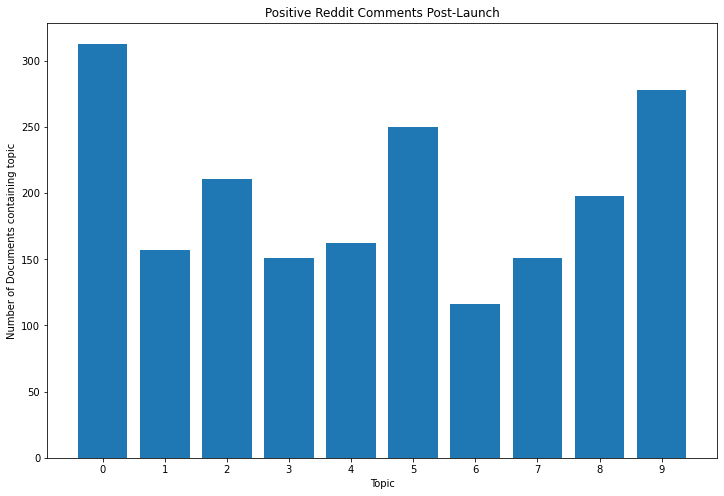

In [50]:
plot_topic_freq(pos_model, pos_features, "Positive Reddit Comments Post-Launch")

In [51]:
#Positive Reddit comments Post-launch
neg_model, neg_features = nmf(aft_neg['cleaned_content'])

+---------+------------------------------------------------------------------------+
|   Topic | Words                                                                  |
+=========+========================================================================+
|       0 | game, setting, ha, make, pc, want, doesnt, great, lot, issue           |
+---------+------------------------------------------------------------------------+
|       1 | like, look, feel, character, weird, dont, make, thing, world, say      |
+---------+------------------------------------------------------------------------+
|       2 | wa, thought, wish, didnt, way, know, quest, going, setting, time       |
+---------+------------------------------------------------------------------------+
|       3 | im, ive, right, time, sure, hour, hate, far, getting, thing            |
+---------+------------------------------------------------------------------------+
|       4 | people, way, dont, thing, ive, day, world, want, know

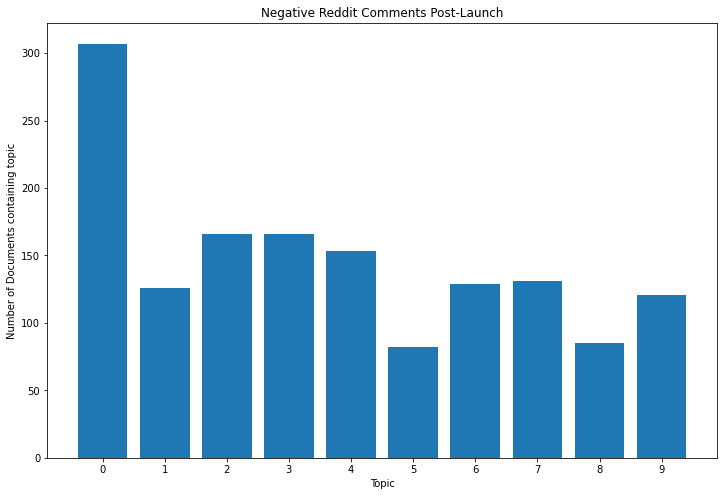

In [52]:
plot_topic_freq(neg_model, neg_features, "Negative Reddit Comments Post-Launch")